In this notebook, I create features for future use in modelling attempts.

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import mca

from pylab import rcParams
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 5, 4
sb.set_style('whitegrid')

In [3]:
listings19 = pd.read_csv('../data19/listings2019_cleaned.csv')
for col in listings19.columns:
    print(col)

id
listing_url
scrape_id
last_scraped
summary
space
description
neighborhood_overview
notes
transit
house_rules
picture_url
host_id
host_url
host_since
host_location
host_about
host_response_time
host_response_rate
host_is_superhost
host_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
smart_location
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
price
guests_included
extra_people
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_nights_avg_ntm
maximum_nights_avg_ntm
calendar_updated
availability_30
availability_60
availability_90
availability_365
calendar_last_scraped
number_of_reviews
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value
requires_lic

In [4]:
X_binary = listings19[['oven','gym','tv','cable','free_parking','breakfast','real_bed',
                        'pets','children','aircon','wifi','washer','garden','dishwasher',
                        'crib','workspace','lift','wheelchair_access','balcony','bathtub',
                        'lugagge_dropoff','self_checkin','dryer','waterfront','fireplace',
                        'host_in_edin','Area_Bruntsfield','Area_Cannonmills','Area_Haymarket',
                        'Area_Leith','Area_Marchmont','Area_Morningside','Area_New Town','Area_Newington',
                        'Area_Old Town','Area_Southside','Area_Stockbridge','Area_Tollcross','Area_West End',
                        'house','apartment','hotel','hostel','host_identity_verified',
                         'host_has_profile_pic','host_is_superhost','other_property_type']]

In [5]:
# drop any columns that are more than 90% just one or zero 
before = set(X_binary.columns)

for column in X_binary:
    percent1s = sum(X_binary[column])/len(X_binary.index) * 100
    if (percent1s > 90) or (percent1s < 10):
        X_binary = X_binary.drop(column, axis = 1)
        
        
after = set(X_binary.columns)

removed = list(before - after)

In [6]:
# remove the uninformative columns from the original dataset

listings19 = listings19.drop(removed, axis = 1)

## Feature Selection

### Principal Components Analysis 

#### Reviews

Notes to self:
-Very simple structure for picking the number of principal components to use (also use skree plot)
-70 - 80% of the information
-Correlation of factors with original variables

I investigate the principal components of the reviews in an attempt to capture the main variance in review scores.

In [7]:
reviews = listings19[['review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                          'review_scores_checkin','review_scores_communication','review_scores_location',
                          'review_scores_value']]

reviews.head()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,99.0,10.0,10.0,10.0,10.0,10.0,10.0
1,92.0,10.0,9.0,10.0,10.0,10.0,9.0
2,93.0,10.0,10.0,10.0,10.0,9.0,10.0
3,98.0,10.0,10.0,10.0,10.0,10.0,10.0
4,97.0,10.0,10.0,10.0,10.0,10.0,10.0


In [8]:
scaler = StandardScaler()
scaled_reviews = scaler.fit_transform(reviews)

In [9]:
pca = decomposition.PCA()
review_pca = pca.fit_transform(scaled_reviews)

pca.explained_variance_ratio_

array([0.58429604, 0.11425823, 0.10484462, 0.05717805, 0.05424936,
       0.05089143, 0.03428227])

The first principal component appears to represent Airbnb's with unusually poor reviews in every category. This is interesting, because in the eda stage I observed that most Airbnbs actually received very good ratings in most categories. However, the review principal components still don't correlate very strongly with price. 

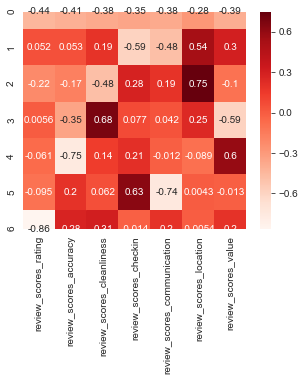

In [10]:
comps = pd.DataFrame(pca.components_, columns=reviews.columns)
comps

sb.heatmap(comps, cmap="Reds", annot=True)

In [11]:
review_pcs = pd.DataFrame(data = review_pca, columns = ['review_pc%s' % num for num in range(7)])
listings19 = pd.concat([review_pcs, listings19], axis = 1)

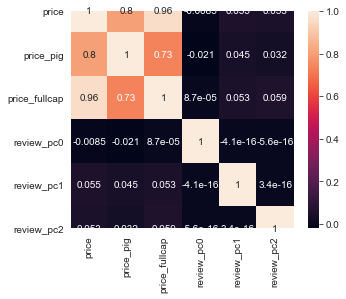

,price,price_pig,price_fullcap,review_pc0,review_pc1,review_pc2
price,1.000000,0.802754,0.962600,-8.525416e-03,5.456811e-02,5.259676e-02
price_pig,0.802754,1.000000,0.734384,-2.141900e-02,4.466084e-02,3.181568e-02
price_fullcap,0.962600,0.734384,1.000000,8.743932e-05,5.280277e-02,5.934161e-02
review_pc0,-0.008525,-0.021419,0.000087,1.000000e+00,-4.096170e-16,-5.575965e-16
review_pc1,0.054568,0.044661,0.052803,-4.096170e-16,1.000000e+00,3.428265e-16
review_pc2,0.052597,0.031816,0.059342,-5.575965e-16,3.428265e-16,1.000000e+00


In [12]:
corrMatrix = listings19[['price', 'price_pig', 'price_fullcap', 'review_pc0', 'review_pc1', 'review_pc2']].corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()
corrMatrix

### Multiple Correspondence Analysis

#### Amenities

There are 15 amenities in the dataset which are encoded 1 for present and 0 for absent. I use multiple correspondence analysis (MCA) to reduce the dimensionality of these binary variables. The `mca` package gives 7 components describing these 15 features. The first component has a reasonably strong correlation with price (0.11).

In [13]:
amenities = X_binary[['oven','tv','cable','free_parking','breakfast',
                        'children','washer','garden','dishwasher',
                        'workspace','lift',
                        'lugagge_dropoff','self_checkin','dryer','fireplace']]

mca_df = mca.MCA(amenities)

In [14]:
# the eigenvalues: the proportion of variance accounted for by each factor 
mca_df.L

array([0.03410509, 0.02428855, 0.01583116, 0.00701056, 0.00576329,
       0.00514845, 0.00442739, 0.00355117, 0.00331706, 0.00166202,
       0.00123129])

In [15]:
# corrections and thresholding leave us with 7 components
mca_fsr = mca_df.fs_r()
mca_fsr.shape

(10767, 7)

In [16]:
amenities_mcs = pd.DataFrame(data = mca_fsr, columns = ['amenities_mc%s' % num for num in range(7)])
listings19 = pd.concat([amenities_mcs, listings19], axis = 1)

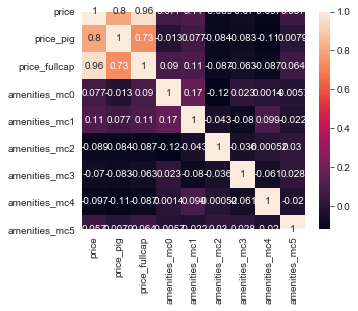

,price,price_pig,price_fullcap,amenities_mc0,amenities_mc1,amenities_mc2,amenities_mc3,amenities_mc4,amenities_mc5
price,1.000000,0.802754,0.962600,0.076719,0.110628,-0.089314,-0.070150,-0.096924,0.057476
price_pig,0.802754,1.000000,0.734384,-0.012732,0.077399,-0.083791,-0.083250,-0.107390,0.007859
price_fullcap,0.962600,0.734384,1.000000,0.090056,0.108316,-0.087395,-0.062592,-0.087114,0.064206
amenities_mc0,0.076719,-0.012732,0.090056,1.000000,0.168796,-0.118243,0.022917,0.001424,-0.005714
amenities_mc1,0.110628,0.077399,0.108316,0.168796,1.000000,-0.042838,-0.080080,0.098731,-0.021715
amenities_mc2,-0.089314,-0.083791,-0.087395,-0.118243,-0.042838,1.000000,-0.035733,-0.000522,0.029725
amenities_mc3,-0.070150,-0.083250,-0.062592,0.022917,-0.080080,-0.035733,1.000000,-0.060606,0.027919
amenities_mc4,-0.096924,-0.107390,-0.087114,0.001424,0.098731,-0.000522,-0.060606,1.000000,-0.020476
amenities_mc5,0.057476,0.007859,0.064206,-0.005714,-0.021715,0.029725,0.027919,-0.020476,1.000000


In [17]:
corrMatrix = listings19[['price', 'price_pig', 'price_fullcap', 'amenities_mc0', 'amenities_mc1',
                         'amenities_mc2','amenities_mc3','amenities_mc4','amenities_mc5']].corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()
corrMatrix

## Initial Modelling

First I attempt a very simple linear regression. This has a coefficient of determination of 0.15.

In [18]:
listings19 = listings19.drop(['listing_url', 'scrape_id', 'last_scraped', 'summary', 'space', 'description', 'neighborhood_overview',
                'notes', 'transit', 'house_rules', 'picture_url', 'host_url', 'host_about', 'street', 'country',
                'calendar_last_scraped'], axis = 1)

In [19]:
X_naive = listings19[['host_response_time', 'host_response_rate','host_listings_count',
                          'latitude','longitude','bath_bed_ratio','host_in_edin','host_is_superhost','host_identity_verified',
                          'apartment','amenities_mc1',
                          'amenities_mc2','amenities_mc3','amenities_mc4','amenities_mc5',
                          'Area_Leith','Area_Old Town','review_pc0', 'review_pc1', 'review_pc2']]

X_naive = scaler.fit_transform(X_naive)

y = scaler.fit_transform(np.array(listings19['price']).reshape(-1, 1))
y = y.reshape(len(y),)

X_train, X_test, y_train, y_test = train_test_split(X_naive, y, test_size=0.2, random_state=101)

In [20]:
regr = LinearRegression()
initial_fit = regr.fit(X_train, y_train)

y_pred = initial_fit.predict(X_test)

print('Coefficients: \n', initial_fit.coef_)
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [ 0.00982878 -0.04525735  0.03052356  0.07884531  0.02288136 -0.27526181
 -0.0453161  -0.05441603  0.01165675 -0.10110442  0.10534635 -0.0384574
 -0.0891784  -0.11115055  0.05473221 -0.15616722  0.05125039 -0.04357542
  0.02052035  0.014518  ]
Mean squared error: 0.82
Coefficient of determination: 0.15


In [21]:
# visualisation of predicted vs true price 
# comparison to 2020 data 

Now I compare the performance of the simple linear regression with the XGBoost algorithm. With the default values, performance is worse than with simple linear regression - the coefficient of determination is only 0.12. However, XGBoost has many hyperparameters that can be tuned to perhaps yield better performance. I played with these parameters but did not see any improvement in the model. 

In [22]:
import xgboost as xgb

In [23]:
xgb_reg = xgb.XGBRegressor(booster = "gblinear", random_state = 101)
xgb_reg.fit(X_train, y_train)
xgb_reg_pred = xgb_reg.predict(X_test)

[13:32:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [24]:
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, xgb_reg_pred))

print('Coefficient of determination: %.2f'
      % r2_score(y_test, xgb_reg_pred))

Mean squared error: 0.85
Coefficient of determination: 0.12


In [33]:
for val in [0.001, 0.01, 0.025, 0.05]:
    print("eta = " + str(val))
    xgb_reg = xgb.XGBRegressor(eta = val, max_depth = 100, booster = "gblinear", random_state = 101)
    xgb_reg.fit(X_train, y_train)
    xgb_reg_pred = xgb_reg.predict(X_test)

    print('Mean squared error: %.2f'
      % mean_squared_error(y_test, xgb_reg_pred))

    print('Coefficient of determination: %.2f'
      % r2_score(y_test, xgb_reg_pred))

eta = 0.001
[13:36:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean squared error: 0.85
Coefficient of determination: 0.12
eta = 0.01
[13:36:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean squared error: 0.85
Coefficient of determination: 0.12
eta = 0.025
[13:36:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean squared error: 0.85
Coefficient of determination: 0.12
eta = 0.05
[13:36:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean squared error: 0.85
Coefficient of determination: 0.12
